# Sentitment Analysis

## Import Dependencies

In [1]:
import re
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from bs4 import BeautifulSoup
import warnings
warnings.simplefilter("ignore")

# Import NLTK for natural language processing
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

# Import TensorFlow and Keras for deep learning
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding,Flatten,Dense,Conv1D,GlobalAveragePooling1D,MaxPooling1D
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers.legacy import Adam
from keras.callbacks import EarlyStopping

# Import scikit-learn functions for data splitting and preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

## Parameters

In [2]:
TRAIN_SIZE= 0.8

MAX_NUM_WORDS = 100000
MAX_SEQUENCE_LEN = 250
EMBEDDING_DIM = 100

EPOCHS = 10
BATCH_SIZE = 32
LR= 0.005

# EXPORT
MODEL_PATH = 'models/sentiment_analysis_model.h5'
TOKENIZER_MODEL = "models/tokenizer.pickle"
ENCODER_MODEL = "models/encoder.pickle"

## Data Loading and Preprocessing

In [3]:
df = pd.read_csv('./Resources/IMDB Dataset.csv', engine='python')

df.columns = ['text', 'target']

**First few rows of DataFrame**

In [4]:
df.head()

,text,target
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


**Last few rows of DataFrame**

In [5]:
df.tail()

,text,target
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative
49999,No one expects the Star Trek movies to be high...,negative


**Dataset Size**

In [6]:
print("Dataset Size:", len(df))

Dataset Size: 50000


**DataFrame Information**

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    50000 non-null  object
 1   target  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


**Target Label Assignment and Sentiment Distribution Analysis**

In the next steps, we aimed for a balanced distribution with roughly equal examples for each class.

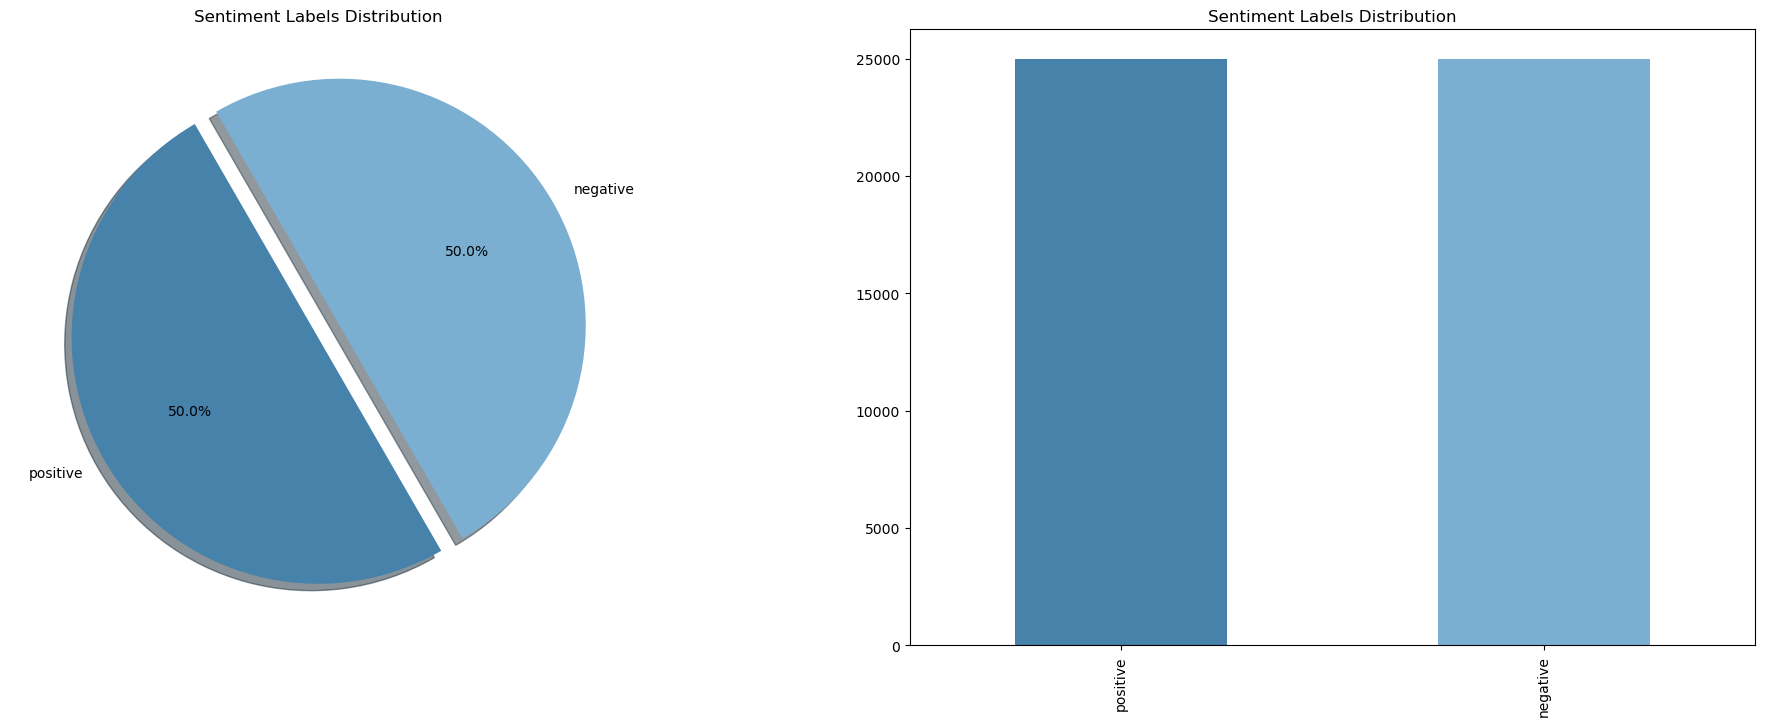

In [8]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(24, 8))

df['target'].value_counts().plot.pie(
    explode=[0, 0.1],
    autopct='%1.1f%%',
    ax=ax1,
    shadow=True,
    startangle=120,
    colors=["#4682A9", "#7BAFD2"]
)
ax1.set_title('Sentiment Labels Distribution')
ax1.set_ylabel('')

df['target'].value_counts().plot(kind="bar", ax=ax2, color=["#4682A9", "#7BAFD2"])
ax2.set_title('Sentiment Labels Distribution')
plt.show()

- The data is uniformly distributed, eliminating the need for resampling.

## Text Data Preprocessing

1. **Lowercasing**: Convert all text to lowercase to ensure uniformity and prevent case-based duplication.
2. **Regex Cleaning**: Use regular expressions (regex) to clean the text. This step removes special characters, URLs, and mentions (e.g., "@username") from the text.
3. **Stopword Removal**: Eliminate common stopwords, such as "the," "and," and "is," from the text. This reduces noise in the data.
4. **HTML Tag Removal**: Parse HTML and retrieve clean, tag-free text.

These preprocessing steps are commonly used to prepare text data for analysis or natural language processing tasks.

In [9]:
stop_words = set(stopwords.words("english"))
stemmer = SnowballStemmer("english")
regex_text = r"[^A-Za-z]+"

In [10]:
def preprocess_text(text, stem=False):
    
    text= BeautifulSoup(text).get_text()
    text = re.sub(regex_text, ' ', str(text).lower()).strip()
    
    tokens = []
    
    for word in text.split():
        if word not in stop_words:
            if stem:
                tokens.append(stemmer.stem(word))
            else:
                tokens.append(word)
                
    return " ".join(tokens)

In [11]:
%%time
df['text']=df['text'].apply(lambda x: preprocess_text(x))

CPU times: user 6.85 s, sys: 12.6 ms, total: 6.86 s
Wall time: 6.58 s


**Positive Words**

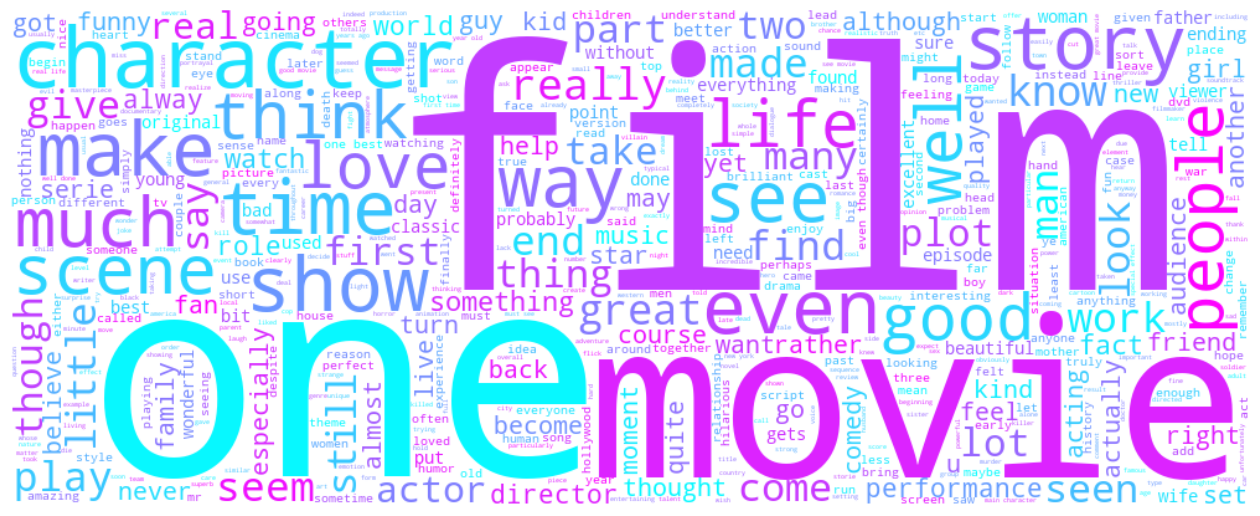

In [12]:
plt.figure(figsize = (16,8))
positive_wordcloud = WordCloud (
                    background_color = 'white',
                    width = 1000,
                    height = 400,
                    colormap = 'cool',
                    max_words=500,
                    contour_width=1,
                    contour_color='steelblue').generate(' '.join(df[df['target'] == 'positive']['text']))

plt.imshow(positive_wordcloud, interpolation= 'bilinear')
plt.axis('off')
plt.show()

**Negative Words**

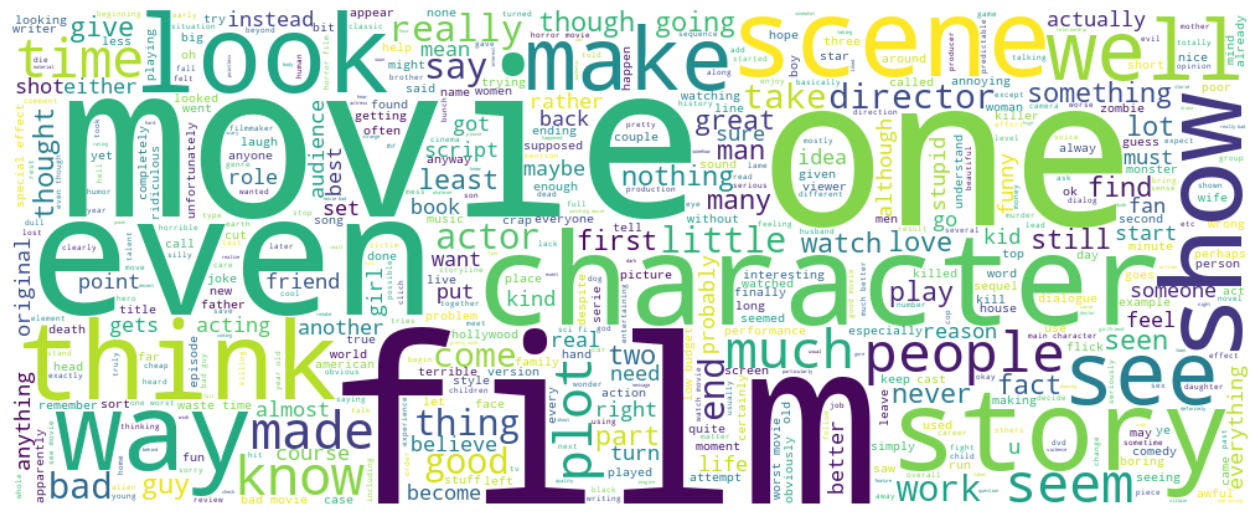

In [13]:
plt.figure(figsize = (16,8))
negative_wordcloud = WordCloud (
                    background_color = 'white',
                    width = 1000,
                    height = 400,
                    colormap = 'viridis',
                    max_words=500,
                    contour_width=1,
                    contour_color='darkred').generate(' '.join(df[df['target'] == 'negative']['text']))

plt.imshow(negative_wordcloud, interpolation= 'bilinear')
plt.axis('off')
plt.show()

- Surprisingly, the word clouds for both positive and negative sentiments yield the same result: "One", "film" and "movie."

### Train and Test Split

In [14]:
train_data, test_data= train_test_split(df, test_size=1-TRAIN_SIZE, random_state=78)

### Tokenization and Padding for Sequences

In [15]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data.text)

word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
print("Total Words :", vocab_size)

Total Words : 92211
CPU times: user 1.78 s, sys: 5.06 ms, total: 1.78 s
Wall time: 1.42 s


In [16]:
%%time
X_train = pad_sequences(tokenizer.texts_to_sequences(train_data['text']), maxlen=MAX_SEQUENCE_LEN)
X_test = pad_sequences(tokenizer.texts_to_sequences(test_data['text']), maxlen=MAX_SEQUENCE_LEN)

print("Train X Shape:", X_train.shape)
print("Test X Shape", X_test.shape)

Train X Shape: (40000, 250)
Test X Shape (10000, 250)
CPU times: user 1.15 s, sys: 9.69 ms, total: 1.16 s
Wall time: 1.17 s


**Label Encoding**

In [17]:
labels= df['target'].unique().tolist()
labels

['positive', 'negative']

In [18]:
encoder = LabelEncoder()
encoder.fit(train_data['target'].to_list())

y_train = encoder.transform(train_data['target'].to_list())
y_test = encoder.transform(test_data['target'].to_list())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (40000, 1)
y_test shape: (10000, 1)


### Word Embedding

Utilizing pre-trained GloVe word vectors improves NLP model performance, minimizes data requirements, and harnesses semantic word representations effectively.

In [19]:
embeddings_index = {}

with open("Resources/glove.6B.100d.txt") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs 

print(f'Found {len(embeddings_index)} word vectors.')

Found 400000 word vectors.


In [20]:
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

## Model Training

### Build the Simple Model

The basic model employs an embedding layer to transform textual tokens into fixed-length vectors. This layer takes the input text sequence and turns it into a sequence of vectors. Subsequently, it applies average pooling operations and concludes with a final fully-connected layer.

In [21]:
def model_builder():
    
    model = Sequential([
        Embedding(embedding_matrix.shape[0],
                            embedding_matrix.shape[1],
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LEN,  
                            trainable=False),
        GlobalAveragePooling1D(),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(1, activation='sigmoid')], name="simple_model")

    return model

In [22]:
model= model_builder()
model.summary()

Model: "simple_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 250, 100)          9221100   
                                                                 
 global_average_pooling1d (  (None, 100)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 flatten (Flatten)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 128)               12928     
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 9234157 (35.23 MB)
Trainable params: 13057 (51.00 KB)
Non-trainable params: 9221100 (35.18 MB)
___________

**Compile the Model**

In [23]:
model.compile(optimizer=Adam(learning_rate=LR), 
              loss=BinaryCrossentropy(),
              metrics=['accuracy'])

In [24]:
# model.compile(optimizer=Adam(learning_rate=LR), 
#               loss=BinaryCrossentropy(),
#               metrics=tf.metrics.BinaryAccuracy(threshold=0.4, name='accuracy'))

**Train the Model**

In [25]:
%%time
history= model.fit(X_train, y_train, 
                   batch_size= BATCH_SIZE,
                   epochs= EPOCHS, 
                   validation_split= 0.1,
                   verbose=1)

Epoch 1/10
1125/1125 [==============================] - 1s 801us/step - loss: 0.4986 - accuracy: 0.7634 - val_loss: 0.4518 - val_accuracy: 0.7890
Epoch 2/10
1125/1125 [==============================] - 1s 754us/step - loss: 0.4516 - accuracy: 0.7905 - val_loss: 0.4380 - val_accuracy: 0.7970
Epoch 3/10
1125/1125 [==============================] - 1s 751us/step - loss: 0.4422 - accuracy: 0.7944 - val_loss: 0.4414 - val_accuracy: 0.7947
Epoch 4/10
1125/1125 [==============================] - 1s 751us/step - loss: 0.4388 - accuracy: 0.7958 - val_loss: 0.4376 - val_accuracy: 0.7997
Epoch 5/10
1125/1125 [==============================] - 1s 744us/step - loss: 0.4331 - accuracy: 0.7982 - val_loss: 0.4401 - val_accuracy: 0.7940
Epoch 6/10
1125/1125 [==============================] - 1s 700us/step - loss: 0.4290 - accuracy: 0.8007 - val_loss: 0.4296 - val_accuracy: 0.8018
Epoch 7/10
1125/1125 [==============================] - 1s 696us/step - loss: 0.4256 - accuracy: 0.8039 - val_loss: 0.4325 -

In [26]:
%%time
loss, accuracy = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE)
print(f"Test loss: {loss:.4f}")
print(f"Test accuracy: {accuracy*100:.2f}%")

313/313 [==============================] - 0s 577us/step - loss: 0.4345 - accuracy: 0.8012
Test loss: 0.4345
Test accuracy: 80.12%
CPU times: user 375 ms, sys: 215 ms, total: 590 ms
Wall time: 243 ms


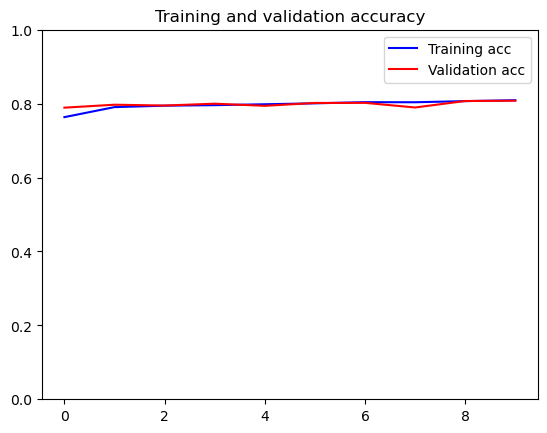

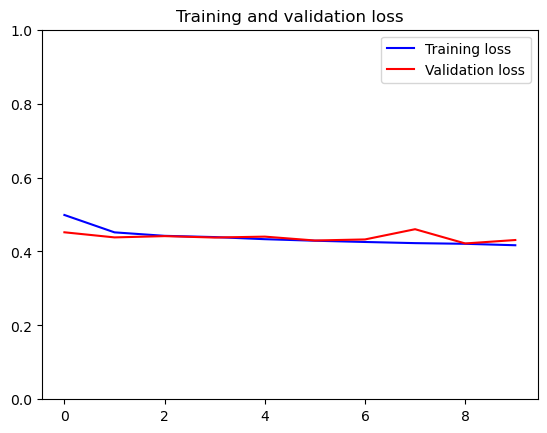

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt .ylim(0,1)
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt .ylim(0,1)
plt.legend()

plt.show()

### Build the Complex Model

CNN (convolutional neural network) is used for our advanced model. This model employs an embedding layer to convert textual tokens into fixed-length vectors, creating a sequence of vectors from the input text. These vectors then undergo several layers of convolution and max pooling operations before reaching a final fully-connected layer. To prevent overfitting, an implemented callback mechanism halts training early if the validation loss fails to improve for a certain number of consecutive times.

In [28]:
def opt_model_builder():
    
    model = Sequential([
        Embedding(embedding_matrix.shape[0],
                            embedding_matrix.shape[1],
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LEN,  
                            trainable=False),
        Conv1D(128, 5, activation='relu', padding="same"),
        MaxPooling1D(5, padding="same"),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(1, activation='sigmoid')], name= "complex_model")

    return model

In [29]:
model= opt_model_builder()
model.summary()

Model: "complex_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 250, 100)          9221100   
                                                                 
 conv1d (Conv1D)             (None, 250, 128)          64128     
                                                                 
 max_pooling1d (MaxPooling1  (None, 50, 128)           0         
 D)                                                              
                                                                 
 flatten_1 (Flatten)         (None, 6400)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               819328    
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                     

**Compile the Model**

In [30]:
model.compile(optimizer=Adam(learning_rate=LR), 
              loss=BinaryCrossentropy(),
              metrics=['accuracy'])

In [31]:
# model.compile(optimizer=Adam(learning_rate=LR), 
#               loss=BinaryCrossentropy(),
#               metrics=tf.metrics.BinaryAccuracy(threshold=0.4, name='accuracy'))

**Callbacks**

In [32]:
callbacks =[EarlyStopping(monitor='val_loss', patience=3)]

**Train the Model**

In [33]:
%%time
history= model.fit(X_train, y_train, 
                   batch_size= BATCH_SIZE,
                   epochs= EPOCHS, 
                   validation_split= 0.1,
                   verbose=1,
                   callbacks= callbacks)

Epoch 1/10
1125/1125 [==============================] - 11s 10ms/step - loss: 0.4676 - accuracy: 0.7714 - val_loss: 0.3831 - val_accuracy: 0.8313
Epoch 2/10
1125/1125 [==============================] - 11s 10ms/step - loss: 0.3630 - accuracy: 0.8420 - val_loss: 0.3971 - val_accuracy: 0.8317
Epoch 3/10
1125/1125 [==============================] - 12s 10ms/step - loss: 0.3242 - accuracy: 0.8607 - val_loss: 0.4204 - val_accuracy: 0.8232
Epoch 4/10
1125/1125 [==============================] - 12s 11ms/step - loss: 0.2750 - accuracy: 0.8857 - val_loss: 0.4500 - val_accuracy: 0.8298
CPU times: user 3min 57s, sys: 40.5 s, total: 4min 38s
Wall time: 46.2 s


### Model Evaluation

In [34]:
%%time
loss, accuracy = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE)
print(f"Test loss: {loss:.4f}")
print(f"Test accuracy: {accuracy*100:.2f}%")

313/313 [==============================] - 1s 3ms/step - loss: 0.4374 - accuracy: 0.8325
Test loss: 0.4374
Test accuracy: 83.25%
CPU times: user 6.65 s, sys: 608 ms, total: 7.25 s
Wall time: 1.17 s


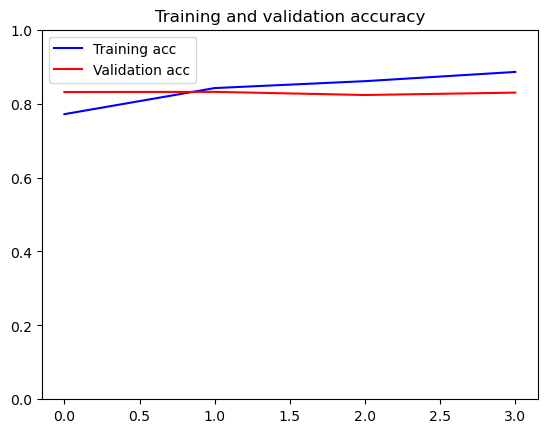

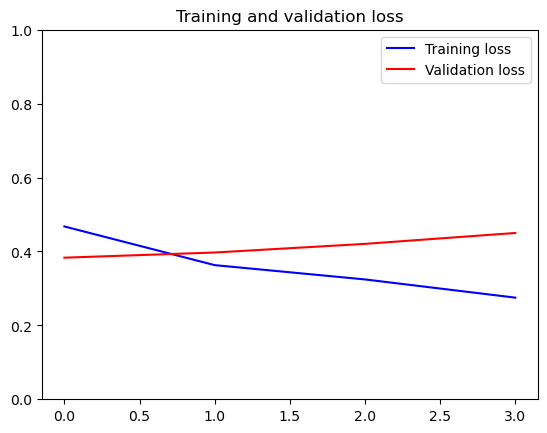

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt .ylim(0,1)
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt .ylim(0,1)
plt.legend()

plt.show()

**Predict**

In [36]:
def decode_sentiment(score):
    return "positive" if score > 0.5 else "negative"

In [37]:
def predict(text):
    # Tokenize text
    X_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=MAX_SEQUENCE_LEN)
    
    # Predict
    score = model.predict([X_test])[0]
    # Decode sentiment
    label = decode_sentiment(score)

    return {"label": label, "score": float(score)}  

In [38]:
predict("The best movie I have ever watched")

1/1 [==============================] - 0s 38ms/step


{'label': 'positive', 'score': 0.9842016100883484}

In [39]:
predict("I hate the movie")

1/1 [==============================] - 0s 7ms/step


{'label': 'negative', 'score': 0.2813010513782501}

**Confusion Matrix**

In [40]:
%%time
scores = model.predict(X_test, verbose=1, batch_size=10000)
y_pred_1d = [decode_sentiment(score) for score in scores]

1/1 [==============================] - 1s 1s/step
CPU times: user 6.74 s, sys: 1.22 s, total: 7.96 s
Wall time: 1.2 s


In [41]:
cm= confusion_matrix(test_data['target'],y_pred_1d)
cm = (cm.astype('float') / cm.sum(axis=1))*100
df_cm= pd.DataFrame(cm, index=['True Positive', 'True Negative'], columns=['Predict Positive', 'Predict Negative'])
df_cm

,Predict Positive,Predict Negative
True Positive,84.417129,15.859564
True Negative,17.624901,82.062147


**Classification Report**

In [42]:
print(classification_report(list(test_data['target']), y_pred_1d))

              precision    recall  f1-score   support

    negative       0.83      0.84      0.84      5044
    positive       0.84      0.82      0.83      4956

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000



### Save the Model

In [43]:
model.save(MODEL_PATH)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=pickle.HIGHEST_PROTOCOL)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=pickle.HIGHEST_PROTOCOL)